In [11]:
# !pip install sqlite3
# !pip install time
# !pip install psutil
# !pip install os
# !pip install tqdm
# !pip install plotly

## _Análise de resultados_

Resultados gerados a partir de registros periódicos ao se realizar inserts no banco de dados.
Para isso foi usado o código `insercao_dados.py`

---

In [16]:
import sqlite3
from tqdm import tqdm
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt


### 1) Input de dados 

Consulta ao banco de dados e tabela de resultados

> Uso de memória em MB.
> Uso de CPU em %.

In [2]:
nm_banco_dados = "sqlite_database.bd"

try:
    connection = sqlite3.connect(nm_banco_dados)

    df_insert_results = pd.read_sql_query("select * from t_sqlite_insert_results", con=connection)
    df_size_results = pd.read_sql_query("select * from t_sqlite_size_results", con=connection)
    print('Consulta ao banco de dados realizada')
except Exception as e:
    print("Erro: ", e)
finally:
    connection.close()
    print("connection closed")

Consulta ao banco de dados realizada
connection closed


In [7]:
df_insert_results.info()
df_insert_results.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20870 entries, 0 to 20869
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            20870 non-null  int64  
 1   time          20870 non-null  float64
 2   memori        20870 non-null  float64
 3   cpu           20870 non-null  float64
 4   nr_registros  20870 non-null  int64  
 5   method        20870 non-null  object 
 6   commit_type   20870 non-null  object 
dtypes: float64(3), int64(2), object(2)
memory usage: 1.1+ MB


,id,time,memori,cpu,nr_registros
count,20870.000000,20870.000000,20870.000000,20870.000000,20870.000000
mean,10435.517250,0.126358,129.205925,8.336325,4796.755199
std,6024.824018,0.089663,86.174430,6.613290,2988.633148
min,1.000000,0.000039,34.914062,0.000000,0.000000
25%,5218.250000,0.061700,88.765625,4.400000,2173.250000
50%,10435.500000,0.111160,88.781250,6.700000,4782.000000
75%,15652.750000,0.166480,109.511719,9.700000,7390.750000
max,20872.000000,3.739193,478.468750,79.600000,9999.000000


In [6]:
df_size_results.info()
df_size_results.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28334 entries, 0 to 28333
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              28334 non-null  int64  
 1   time            28334 non-null  float64
 2   memori          28334 non-null  float64
 3   cpu             28334 non-null  float64
 4   nr_registros    14167 non-null  float64
 5   method          28334 non-null  object 
 6   commit_type     14167 non-null  object 
 7   data_base_size  14167 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.7+ MB


,id,time,memori,cpu,nr_registros,data_base_size
count,28334.0000,28334.000000,28334.000000,28334.000000,1.416700e+04,14167.000000
mean,14167.5000,0.651849,98.802873,7.757997,3.342222e+07,3824.480303
std,8179.4656,0.726068,2.316127,8.048086,2.990392e+07,857.585356
min,1.0000,0.000098,35.789062,0.600000,8.000000e+01,2867.328100
25%,7084.2500,0.177579,98.910156,3.900000,6.258828e+06,3045.091800
50%,14167.5000,0.396332,98.910156,5.000000,2.505977e+07,3584.535200
75%,21250.7500,0.734485,98.953125,7.700000,5.640293e+07,4483.568400
max,28334.0000,10.755008,98.968750,64.200000,1.000054e+08,5734.058600


Temos 2 datasets
1. df_insert_results: Registro de tempo para se inserir uma linha ao banco de dados 
2. df_size_results: Registro de tempo de consulta conforme aumenta o banco de dados 

---

### 2) Análise exploratória  
_df_insert_results_

In [8]:
df_insert_results.select_dtypes([float, int]).columns

Index(['id', 'time', 'memori', 'cpu', 'nr_registros'], dtype='object')

In [15]:
df_insert_corr = df_insert_results[["time", "memori", "cpu", "nr_registros"]].corr()

# Criar o mapa de calor com Plotly
fig = px.imshow(df_insert_corr, text_auto=True, aspect='auto', color_continuous_scale='RdBu_r')
fig.show()


- Como esperado, a maior correlação está entre o 'tempo' e 'número de registros' inseridos.
- Também temos uma relação entre a memória e número de registros.
- Pelo que parece a CPU quase não interfere no processo.

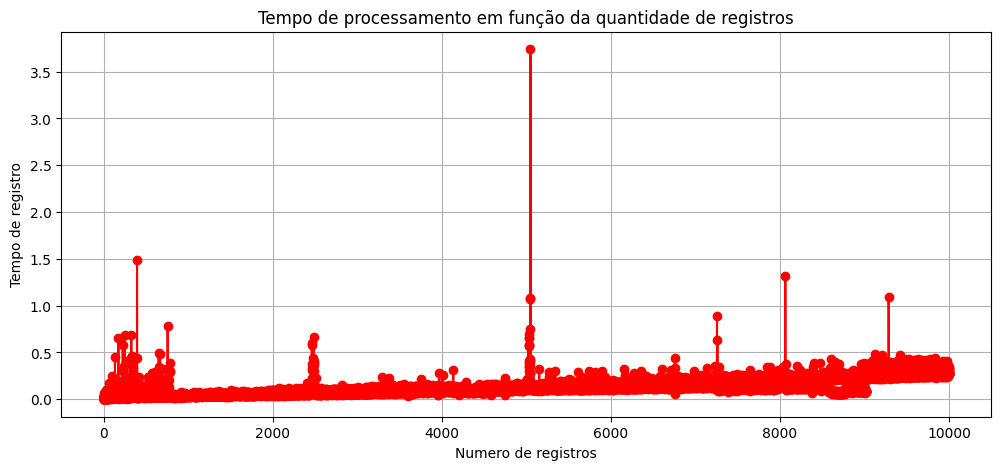

In [47]:
# Plotar um gráfico de tendencia de registros e tempo
df_tempo_registro = df_insert_results[["nr_registros", "time"]]
plt.figure(figsize=(12, 5))
plt.plot(df_tempo_registro['nr_registros'], df_tempo_registro['time'], marker='o', linestyle='-', color='r')
plt.xlabel('Numero de registros')
plt.ylabel('Tempo de registro')
plt.title("Tempo de processamento em função da quantidade de registros")
plt.grid(True)
plt.show()

In [50]:
df_insert_results['commit_type'].unique()

array(['per_row', 'batch'], dtype=object)

Separar pelos 2 Tipos de inserts
- per_row
- batch

In [53]:
df_insert_per_row = df_insert_results[df_insert_results['commit_type'] == 'per_row']
df_insert_batch = df_insert_results[df_insert_results['commit_type'] == 'batch']
df_insert_per_row_corr = df_insert_per_row[["time", "memori", "cpu", "nr_registros"]].corr()
df_insert_batch_corr = df_insert_batch[["time", "memori", "cpu", "nr_registros"]].corr()

In [60]:
fig = px.imshow(df_insert_per_row_corr, text_auto=True, aspect='auto', color_continuous_scale='RdBu_r',title='Inserir dados por linha')
fig.show()


In [ ]:
fig = px.imshow(
    df_insert_batch_corr,
    text_auto=True,
    aspect="auto",
    color_continuous_scale="RdBu_r",
    title="Inserir dados batch",
)
fig.show()

Separando os dois modos de inserir dados, temos que o método 'batch' tem maior correlação com a memória e tempo.
Vimos que o método 'per_row' quase não tem correlação com a memória.
